# Large datasets experiments

In this notebook, we will test the distributed implementation of the coordinate
solver for HSIC lasso on larger datasets.

In [1]:
from pathlib import Path

import numpy as np
import h5py
import dask
from dask.distributed import Client
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

from hsic_optimization.cluster import PatchedSLURMCluster
from hsic_optimization.hsic_tools import generate
from hsic_optimization.hsic_lasso import cd_hsic_lasso, feature_accel  # NOQA
from hsic_optimization.optimization import cd_nn_lasso_path  # NOQA

/home/riom/project/hsic_optimization/venv/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Dataset and parameter generation

Here we generate a dataset big enough to become representative of the final
application, with 1 million samples. The dataset is save on-disk in a compressed
format to save space.

In [2]:
n_samples = 1_000_000
n_features = 200
n_active = 10
dset_file = Path(f"../data/test_dataset_{n_features}_by_{n_samples}.h5")

In [3]:
if not dset_file.exists():
    generate(dset_file, samples=n_samples, feats=n_features, active=n_active, seed=1234)

## Slurm-based Dask cluster

In [4]:
_ = dask.config.set(
    {
        "distributed.worker.memory.target": False,  # avoid spilling to disk
        "distributed.worker.memory.spill": False,  # avoid spilling to disk
        "distributed.worker.memory.pause": 0.80,  # pause execution at 80% memory use
        "distributed.worker.memory.terminate": 0.95,  # restart the worker at 95% use
    }
)

In [5]:
cluster = PatchedSLURMCluster(
    cores=4,
    processes=4,
    memory="8GiB",
    walltime="0-00:20",
    log_directory="../dask/logs",
    local_directory="../dask",
    interface="ib0",
)
client = Client(cluster)

In [6]:
cluster.scale(n=20)
client.wait_for_workers(20)

## Loading function

In [7]:
with h5py.File(dset_file, "r") as fd:
    Y = np.array(fd["Y"])

In [8]:
def raw_feature(i):
    with h5py.File(dset_file, "r") as fd:
        return fd["X"][i]

In [9]:
%timeit raw_feature(10)

3.5 ms ± 64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## CD solver performances

In [10]:
cd_hsic_kwargs = {
    "X": raw_feature,
    "Y": Y,
    "B": 20,
    "M": 3,
    "num_feat": 10,
    "feature": feature_accel,
    "n_features": n_features,
    "client": client,
    "chunksize": 5,
}

CPU times: user 49.9 s, sys: 30.9 s, total: 1min 20s
Wall time: 4min 4s


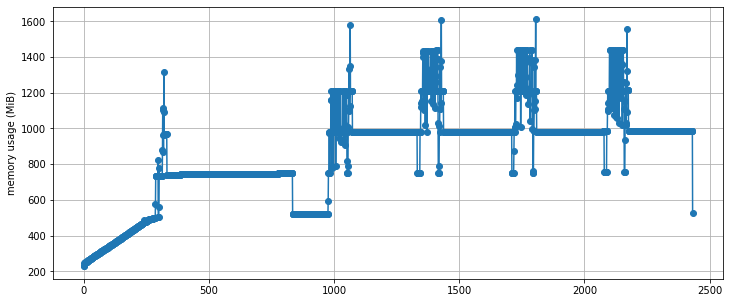

In [11]:
%%time
mem_use = memory_usage((cd_hsic_lasso, (), {"max_outer_iter": 5, **cd_hsic_kwargs}))

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

In [12]:
%load_ext line_profiler

In [13]:
%lprun -f cd_nn_lasso_path cd_hsic_lasso(max_outer_iter=10, **cd_hsic_kwargs)

Timer unit: 1e-06 s

Total time: 375.808 s
File: /scale_wlg_persistent/filesets/project/nesi99999/riom/hsic_optimization/src/hsic_optimization/optimization.py
Function: cd_nn_lasso_path at line 147

Line #      Hits         Time  Per Hit   % Time  Line Contents
   147                                           def cd_nn_lasso_path(
   148                                               features: T.Union[np.ndarray, Operator],
   149                                               y: np.ndarray,
   150                                               max_features: int,
   151                                               eps: float = 0.95,
   152                                               max_outer_iter: int = 100,
   153                                               max_inner_iter: int = 2000,
   154                                               abstol: float = 1e-6,
   155                                               checkpoint: T.Optional[Path] = None,
   156                             

## Shutdown the Dask cluster

Finally, we close the Dask cluster to release resources.

In [14]:
cluster.close()
client.close()